In [1]:
import function_file as ff
import importlib
importlib.reload(ff)

<module 'function_file' from 'c:\\Users\\Sejong\\Desktop\\hanhwa\\function_file\\__init__.py'>

In [13]:
from function_file.time_series import time_series_dataframe
data = time_series_dataframe()
data

,TEMP,label,TIME
0,286.797,1,0
1,287.082,1,1
2,285.938,1,2
3,285.772,1,3
4,286.357,1,4
...,...,...,...
664791,865.029,11,664791
664792,864.985,11,664792
664793,865.048,11,664793
664794,865.040,11,664794


In [16]:
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df, lookback_size,output_size):
    df = dc(df)
    
    for i in range(1,lookback_size+1):
        df[f'TEMP(t-{i})'] = df['TEMP'].shift(i)

    for j in range(1,output_size + 1):
        df[f'TEMP(t+{j})'] = df['TEMP'].shift(-j)
    df.dropna(inplace=True)
    return df

def multi_step_LSTM(df, lookback_size, output_size, batch_size):
    shifted_df = prepare_dataframe_for_lstm(df, lookback_size,output_size)

In [3]:
from sklearn.preprocessing import MinMaxScaler

df = data['TEMP']
train_len = int(len(df) * 0.8)

shifted_df = prepare_dataframe_for_lstm(data, 30,9)
shifted_df.columns

NameError: name 'prepare_dataframe_for_lstm' is not defined

In [ ]:
shifted_df

## LSTM Multistep

In [39]:
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
window_size = 30
output_size = 10

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(window_size,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(window_size,1))
    return input, target

import math
import time
model = LSTM(1,4,1).to(device)
batch_size = 512
lr = 0.001
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
criterion = nn.MSELoss()
def train(train_data):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, target = get_batch(train_data, i, batch_size)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output[-output_size:], target[-output_size:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


import numpy as np
import torch
from matplotlib import pyplot
window_size = 30
output_size = 10
df = data['TEMP'].values
def create_inout_sequences(input_data, window_size):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window_size):
        train_seq = np.append(input_data[i:i+window_size][:-output_size] , output_size * [0])
        train_label = input_data[i:i+window_size]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)


def plot_and_loss(eval_model, data_source):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)
            
            total_loss += criterion(output[-output_size:], target[-output_size:]).item()
            
            test_result = torch.cat((test_result, output[-output_size:].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-output_size:].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()

    test_result = scaler_test.inverse_transform(test_result.reshape(-1,1)).reshape(-1)
    truth = scaler_test.inverse_transform(truth.reshape(-1,1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth,color="blue")
    #pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.ylim([600,900])
    pyplot.show()
    pyplot.close()

    return test_result, truth, total_loss / i

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 512
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0])* criterion(output[-output_size:], targets[-output_size:]).cpu().item()            
    return total_loss / len(data_source)

train_len = int(len(df) * 0.8)
train_data = df[:train_len]
test_data = df[train_len:]
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
train_data = scaler_train.fit_transform(train_data.reshape(-1,1)).reshape(-1)
test_data = scaler_test.fit_transform(test_data.reshape(-1,1)).reshape(-1)


train_sequence = create_inout_sequences(train_data,window_size)
test_data = create_inout_sequences(test_data,window_size)
train_sequence = train_sequence[:-output_size]
test_data = test_data[:-output_size]

train_sequence = train_sequence.to(device)
test_data = test_data.to(device)

| epoch   1 |   207/ 1038 batches | lr 0.001000 |  5.38 ms | loss 0.00368 | ppl     1.00
| epoch   1 |   414/ 1038 batches | lr 0.001000 |  4.99 ms | loss 0.00138 | ppl     1.00
| epoch   1 |   621/ 1038 batches | lr 0.001000 |  4.78 ms | loss 0.00148 | ppl     1.00
| epoch   1 |   828/ 1038 batches | lr 0.001000 |  4.90 ms | loss 0.00221 | ppl     1.00
| epoch   1 |  1035/ 1038 batches | lr 0.001000 |  6.37 ms | loss 0.00215 | ppl     1.00
------------------------------------------------------------------------------------------
| end of epoch   1 | time:  6.38s | valid loss 0.24553 | valid ppl     1.28 |
------------------------------------------------------------------------------------------
| epoch   2 |   207/ 1038 batches | lr 0.001000 |  4.97 ms | loss 0.07748 | ppl     1.08
| epoch   2 |   414/ 1038 batches | lr 0.001000 |  5.10 ms | loss 0.00153 | ppl     1.00
| epoch   2 |   621/ 1038 batches | lr 0.001000 |  4.92 ms | loss 0.00141 | ppl     1.00
| epoch   2 |   828/ 1038 ba

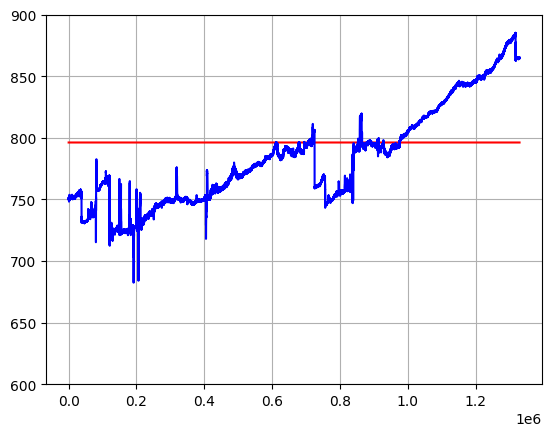

TypeError: cannot unpack non-iterable NoneType object

In [40]:
epochs = 100
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
import warnings 
warnings.filterwarnings('ignore')
for epoch in range(1,epochs+1):
    epoch_start_time = time.time()
    train(train_sequence)

    if (epoch % 5 == 0):
        test_result, truth, val_loss = plot_and_loss(model, test_data)

    else:
        val_loss = evaluate(model, test_data)

    print('-' * 90)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f} |'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 90)

In [15]:
train_sequence.shape

torch.Size([531806, 2, 30])

In [5]:
!nvidia-smi

Wed Dec  6 10:56:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8              39W / 340W |   1323MiB / 10240MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [17]:
import torch
torch.cuda.is_available()

True

## 여기까지

In [10]:
data[0][0]

tensor([286.7970, 287.0820, 285.9380, 285.7720, 286.3570, 286.2770, 285.3190,
        285.0250, 284.9260, 285.1400, 285.5990, 285.8470, 286.6900, 286.4550,
        286.5330, 286.3730, 286.3090, 285.8390, 284.9660, 284.4830,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000])

In [40]:
import numpy as np
import pandas as pd
y = pd.concat([shifted_df.iloc[:, 0], shifted_df.iloc[:, 31:]], axis = 1)
X = shifted_df.iloc[:, 1:31]

In [41]:
X = X.values
y = y.values

X.shape, y.shape

((664757, 30), (664757, 10))

In [42]:
train_len = int(len(X) * 0.8)
X_train = X[:train_len]
y_train = y[:train_len]

X_test = X[train_len:]
y_test = y[train_len:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((531805, 30), (531805, 10), (132952, 30), (132952, 10))

In [43]:
import torch
lookback_size = 30
output_size = 10
X_train = X_train.reshape((-1,lookback_size,1))
X_test = X_test.reshape((-1,lookback_size, 1))
y_train = y_train.reshape((-1, output_size, 1))
y_test = y_test.reshape((-1, output_size, 1))

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [72]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([531805, 30, 1]),
 torch.Size([531805, 10, 1]),
 torch.Size([132952, 30, 1]),
 torch.Size([132952, 10, 1]))

In [68]:
from torch.utils.data import Dataset,DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        #out = self.fc(out[:, -1, :])
        return out

In [69]:
model = LSTM(1,4,1).to(device)
lr = 0.001
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)
criterion = nn.MSELoss()
def train():
    model.train()
    training_loss = 0.0

    for batch in train_loader:
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(X_batch)
        loss = criterion(output, y_batch)
        training_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [73]:
for batch in train_loader:
    A, B = batch[0].to(device), batch[1].to(device)
    break


In [78]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out
    
print(A.shape)
model = LSTM(1,4,1).to(device)
output = model(A)
output.shape

torch.Size([512, 30, 1])


torch.Size([512, 30, 1])

In [48]:
import warnings
warnings.filterwarnings('ignore')
for i in range(10):
    train()

c:\Users\Sejong\Desktop\hanhwa\hanhwa\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([512, 10, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (512) must match the size of tensor b (10) at non-singleton dimension 1

In [20]:
import os
os.environ['CUDA_VISIBLE_DEViCES'] ="-1"

In [19]:
torch.cuda.is_available()

True